---
layout: post
title: Extending the SIR Model
category: data science
tags:
    - python
    - notebook
    - COVID-19
---

To address my [previous post's]({{ site.baseurl }}{% post_url 2010-07-21-name-of-post %}) extreme predictions, we will extend the model and draw some conclusions from China's data that will help create more accurate long term predictions.

# Base SIR Model Review

The base SIR model has 3 compartments: Susceptible, Infected, and Removed, to model the spread of a virus in a population of any size. The model defines the growth rate for each compartment

$$
\frac{dS}{dt} = -\frac{\beta S I}{N} \\
\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} = \gamma I
$$

Solving this ODE can create a robust model that in the past has been extremely effective in modeling widespread disease outbreaks.

## Limits of the Model

While the SIR Model is a great model, there are a few assumptions it makes that in this particular outbreak are not accurate:

- **Infections and symptoms happen immediately**: What makes COVID-19 rather dangerous is its relatively long ([sources](https://www.cdc.gov/coronavirus/2019-ncov/hcp/faq.html) say anywhere between 2 - 14 days) incubation period. During this time, an individual may be able to spread the disease without knowing, which is contributing to a significant growth of infections.
- **Everyone in the population has the same chance to get the virus**: At the time of writing a significant amount of people are practicing social distancing, which helps to slow the spread of the virus.
- **Every infected person can spread the disease**: Similar to the previous point, those that are infected are encouraged to stay at home so that they do not infect others.

# Data

We will be making use of the same JHU dataset

NOTE: in this notebook we WILL be making use of the "recovered" dataset, but only for China, where the virus has already had time to spread and recede. It is still infeasible to make use of this data for the rest of the world because it is an extremely difficult metric to track globally. With the results we get from China we will be able to get information like the mean mortality rate, which from there we will be able to project to the rest of the world.

# Adding Social Distancing in the SIR Model

We will make a new compartmental model to reflect our data and some of the limitations we found of the base SIR model:

This model will have seven compartments:

- Susceptible
- Distanced
- Infected
- Quarantined
- Recovered
- Dead

Each compartment will interact with the others following this ODE:

$$
\frac{dS}{dt} = -\frac{\beta S I}{N} + \epsilon D_i - \delta S \\
\frac{dD_i}{dt} = \delta S - \epsilon D_i \\
\frac{dI}{dt} = \frac{\beta S I}{N} - (\alpha + \gamma + \sigma) I \\
\frac{dQ}{dt} = \sigma I - (\alpha + \gamma) Q \\
\frac{dR}{dt} = \gamma (I + Q) \\
\frac{dD_e}{dt} = \alpha (I + Q)
$$

With the following variables:

- $\alpha$: Mortality rate
- $\beta$: Infection rate
- $\gamma$: Recovery rate
- $\delta$: Social distancing rate
- $\epsilon$: Reintroduction rate after social distancing
- $\sigma$: Quarantining rate

## Fitting to Data Considerations

The data we receive has only 3 compartments:

- Confirmed
- Recovered
- Dead

We can create our "Infected" compartment $I = C - (R + D_e)$.

Our data does not distinguish between those whom are susceptible, distanced or infected, so to fit our data we will match up the sum of the models susceptible and distanced sets.

Our data also does not distinguish between quarantined and infected individuals, so we will fit our data with the sum of infected and quarantined people.

### China Data vs. World Data

China - as the origin of the virus - is quite far ahead of the rest of the world and has already noticed a decline in active cases over the past couple weeks. Its set of recovered cases is more accurate than the data from the rest of the world, so from this fit we can learn some things about the virus that we can use to fit to the world dataset better. Particularly, we can reuse the ratio $\frac{\alpha}{\gamma}$ as the mortality rate to reduce the number of values we need to fit.

## Example

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from git import Repo
import seaborn as sns
from scipy import optimize
from datetime import datetime
from datetime import timedelta
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_log_error as MSLE

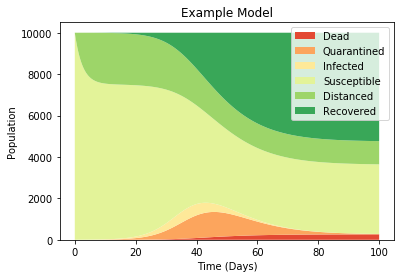

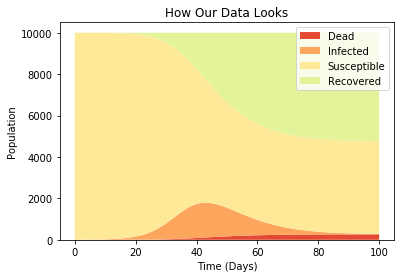

In [33]:
N = 10000
Di0, I0, Q0, R0, De0 = 0, 1, 0, 0, 0
S0 = N - Di0 - I0 - Q0 - R0 - De0
alpha, beta, gamma, delta, epsilon, sigma = 0.005, 0.8, 1/10, 0.1, 0.3, 0.3
t = np.linspace(0, 100, 1000)

# The SDiIQRDe model differential equations.
def SDiIQRDe_ode(y, t, N, alpha, beta, gamma, delta, epsilon, sigma):
    S, Di, I, Q, R, De = y
    dSdt = -beta * S * I / N + epsilon * Di - delta * S
    dDidt = delta * S - epsilon * Di
    dIdt = beta * S * I / N - (alpha + gamma + sigma) * I
    dQdt = sigma * I - (alpha + gamma) * Q
    dRdt = gamma * (I + Q)
    dDedt = alpha * (I + Q)
    return dSdt, dDidt, dIdt, dQdt, dRdt, dDedt

# Initial conditions vector
y0 = S0, Di0, I0, Q0, R0, De0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SDiIQRDe_ode, y0, t, args=(N, alpha, beta, gamma, delta, epsilon, sigma))
S, Di, I, Q, R, De = ret.T

# Plot
pal = sns.color_palette("RdYlGn")
plt.title("Example Model")
plt.stackplot(t, [De, Q, I, S, Di, R],
        labels=["Dead", "Quarantined", "Infected", "Susceptible", "Distanced", "Recovered"],
        colors=pal)
#plt.plot(t, S)
plt.xlabel('Time (Days)')
plt.ylabel('Population')
plt.legend()
plt.show()

plt.title("How Our Data Looks")
plt.stackplot(t, [De, Q + I, S + Di, R],
        labels=["Dead", "Infected", "Susceptible", "Recovered"],
        colors=pal)
plt.xlabel('Time (Days)')
plt.ylabel('Population')
plt.legend()
plt.show()

Let's load in our data:

In [3]:
repo_path = "../../../"
data_root = "../../../scripts/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
repo = Repo(repo_path)
output = repo.git.submodule('update', '--remote')

In [4]:
world_pop = 7.86e9
china_pop = 1.386e9

global_confirmed = pd.read_csv(os.path.join(data_root, "time_series_covid19_confirmed_global.csv"))
global_deaths = pd.read_csv(os.path.join(data_root, "time_series_covid19_deaths_global.csv"))
global_recovered = pd.read_csv(os.path.join(data_root, "time_series_covid19_recovered_global.csv"))

china_confirmed = global_confirmed[global_confirmed['Country/Region'] == "China"].copy()
china_deaths = global_deaths[global_deaths['Country/Region'] == "China"].copy()
china_recovered = global_recovered[global_recovered['Country/Region'] == "China"].copy()
china_deaths.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
china_confirmed.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
china_recovered.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
global_deaths.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
global_confirmed.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
global_recovered.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)


global_confirmed = global_confirmed.sum()
global_deaths = global_deaths.sum()
global_recovered = global_recovered.sum()
china_confirmed = china_confirmed.sum()
china_recovered = china_recovered.sum()
china_deaths = china_deaths.sum()

world_df = pd.DataFrame({
    "Deaths": global_deaths,
    "Infected": global_confirmed - global_recovered.values - global_deaths.values,
    "Susceptible": world_pop - global_confirmed.values,
    "Recovered": global_recovered,
})

china_df = pd.DataFrame({
    "Deaths": china_deaths,
    "Infected": china_confirmed - china_recovered.values - china_deaths.values,
    "Susceptible": china_pop - china_confirmed.values,
    "Recovered": china_recovered,
})

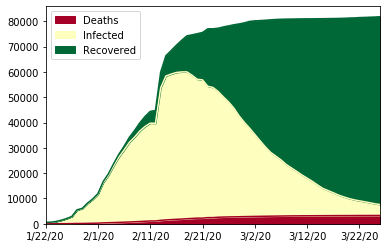

In [5]:
china_df.drop(columns="Susceptible").plot.area(colormap="RdYlGn")

In [6]:
def train_valid_split(df, valid_size = 7):
    x = np.arange(len(df))
    S = df['Susceptible'].values
    I = df['Infected'].values
    R = df['Recovered'].values
    De = df['Deaths'].values
    
    x_train = x[:-valid_size]
    S_train = S[:-valid_size]
    I_train = I[:-valid_size]
    R_train = R[:-valid_size]
    De_train = De[:-valid_size]
    
    x_valid = x[-valid_size:]
    S_valid = S[-valid_size:]
    I_valid = I[-valid_size:]
    R_valid = R[-valid_size:]
    De_valid = De[-valid_size:]
    
    return (x_train, S_train, I_train, R_train, De_train), (x_valid, S_valid, I_valid, R_valid, De_valid)

def plot_data(title, x_train, y_train, x_valid, y_valid, y_fit = None, y_pred = None):
    plt.title(title)
    plt.plot(x_train, y_train, 'o', label="Train")
    plt.plot(x_valid, y_valid, 'o', label="Valid")
    if not y_fit is None:
        plt.plot(x_train, y_fit, label="Fit")
    if not y_pred is None:
        plt.plot(x_valid, y_pred, label="Prediction")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.show()
    if not y_pred is None:
        print(title, "MSLE: {:.4e}".format(MSLE(y_valid, y_pred)))
        print()

In [37]:
def opt_func(t, alpha, beta, gamma, delta, epsilon, sigma, SIR0, N):
    ret = odeint(SDiIQRDe_ode, SIR0, t, args=(N, alpha, beta, gamma, delta, epsilon, sigma))
    S, Di, I, Q, R, De = ret.T
    I = I + Q
    S = S + Di
    return np.concatenate([S, I, R, De])

In [38]:
valid_size = 7
train, valid = train_valid_split(china_df)
x_train, S_train, I_train, R_train, De_train = train
x_valid, S_valid, I_valid, R_valid, De_valid = valid

S0 = S_train[0]
Di0 = 0
I0 = I_train[0]
Q0 = 0
R0 = R_train[0]
De0 = De_train[0]
SIR0 = S0, Di0, I0, Q0, R0, De0
N = sum(SIR0)

In [52]:
(alpha, beta, gamma, delta, epsilon, sigma), _ = optimize.curve_fit(
    lambda t, a, b, g, d, e, s: opt_func(t, a, b, g, d, e, s, SIR0, N),
    x_train, np.concatenate([S_train, I_train, R_train, De_train])
    , bounds=((0, 0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))
alpha, beta, gamma, delta, epsilon, sigma

(0.001578314293853962,
 3.770587849946374,
 0.03754063253059739,
 0.37211504998834427,
 0.7852051967714886,
 2.5540630588444393)

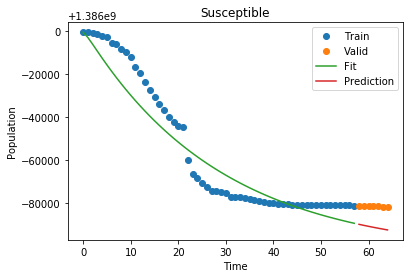

Susceptible MSLE: 4.9537e-11



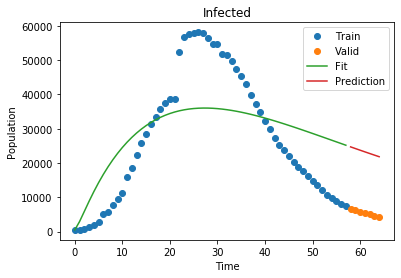

Infected MSLE: 2.1520e+00



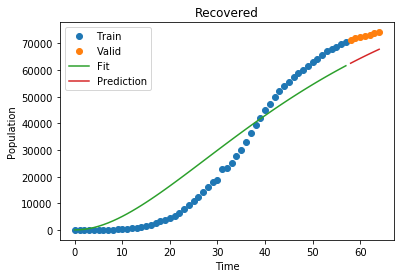

Recovered MSLE: 1.2316e-02



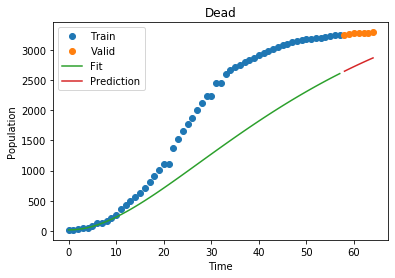

Dead MSLE: 3.0060e-02



In [53]:
ret = odeint(SDiIQRDe_ode, SIR0, np.concatenate([x_train, x_valid]),
             args=(N, alpha, beta, gamma, delta, epsilon, sigma))
S, Di, I, Q, R, De = ret.T
I = I + Q
S = S + Di

S_fit = S[:-valid_size]
S_pred = S[-valid_size:]
I_fit = I[:-valid_size]
I_pred = I[-valid_size:]
R_fit = R[:-valid_size]
R_pred = R[-valid_size:]
De_fit = De[:-valid_size]
De_pred = De[-valid_size:]

plot_data("Susceptible", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
plot_data("Infected", x_train, I_train, x_valid, I_valid, I_fit, I_pred)
plot_data("Recovered", x_train, R_train, x_valid, R_valid, R_fit, R_pred)
plot_data("Dead", x_train, De_train, x_valid, De_valid, De_fit, De_pred)

I = I - Q
S = S - E - Di

In [54]:
alpha / gamma * 100

4.204282633137738

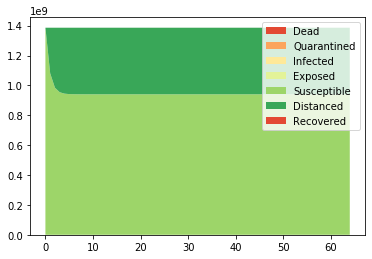

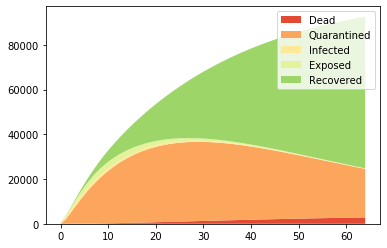

In [55]:
plt.stackplot(np.concatenate([x_train, x_valid]), [De, Q, I, E, S, Di, R],
        labels=["Dead", "Quarantined", "Infected", "Exposed", "Susceptible", "Distanced", "Recovered"],
        colors=pal)
plt.legend()
plt.show()

plt.stackplot(np.concatenate([x_train, x_valid]), [De, Q, I, E, R],
        labels=["Dead", "Quarantined", "Infected", "Exposed", "Recovered"],
        colors=pal)
plt.legend()
plt.show()

In [56]:
train, valid = train_valid_split(world_df)
x_train, S_train, I_train, R_train, De_train = train
x_valid, S_valid, I_valid, R_valid, De_valid = valid

S0 = S_train[0]
Di0 = 0
I0 = I_train[0]
Q0 = 0
R0 = R_train[0]
De0 = De_train[0]
SIR0 = S0, Di0, I0, Q0, R0, De0
N = sum(SIR0)

(alpha, beta, gamma, delta, epsilon, sigma), _ = optimize.curve_fit(
    lambda t, a, b, g, d, e, s: opt_func(t, a, b, g, d, e, s, SIR0, N),
    x_train, np.concatenate([S_train, I_train, R_train, De_train]),
    bounds=((0, 0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)),
    maxfev=1000)
alpha, beta, gamma, delta, epsilon, sigma

(0.29240586491279674,
 3.1058376226422553,
 0.8028133582066023,
 1.7909978180384851,
 2.027188419428303,
 0.5271589125078296)

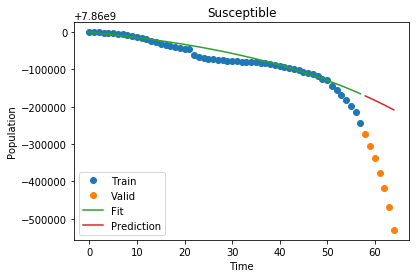

Susceptible MSLE: 7.1614e-10



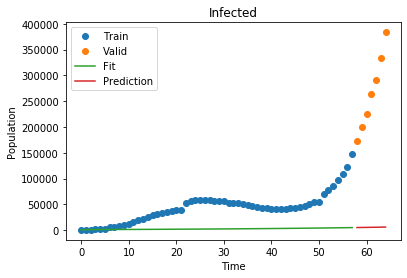

Infected MSLE: 1.4769e+01



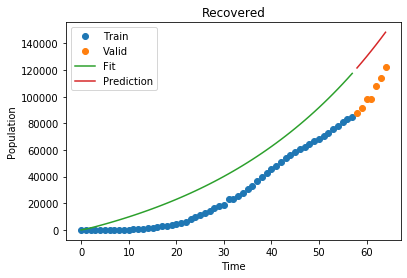

Recovered MSLE: 7.7293e-02



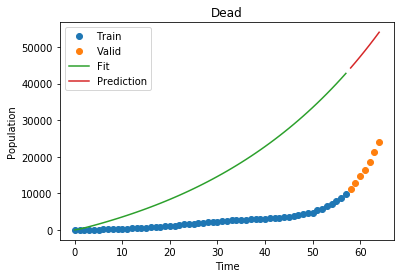

Dead MSLE: 1.2128e+00



In [59]:
ret = odeint(SDiIQRDe_ode, SIR0, np.concatenate([x_train, x_valid]),
             args=(N, alpha, beta, gamma, delta, epsilon, sigma))
S, Di, I, Q, R, De = ret.T
I = I + Q
S = S + Di

S_fit = S[:-valid_size]
S_pred = S[-valid_size:]
I_fit = I[:-valid_size]
I_pred = I[-valid_size:]
R_fit = R[:-valid_size]
R_pred = R[-valid_size:]
De_fit = De[:-valid_size]
De_pred = De[-valid_size:]

plot_data("Susceptible", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
plot_data("Infected", x_train, I_train, x_valid, I_valid, I_fit, I_pred)
plot_data("Recovered", x_train, R_train, x_valid, R_valid, R_fit, R_pred)
plot_data("Dead", x_train, De_train, x_valid, De_valid, De_fit, De_pred)

I = I - Q
S = S - E - Di

In [60]:
x = np.concatenate([x_train, x_valid])
S = np.concatenate([S_train, S_valid])
I = np.concatenate([I_train, I_valid])
R = np.concatenate([R_train, R_valid])
De = np.concatenate([De_train, De_valid])

(alpha, beta, gamma, delta, epsilon, sigma), _ = optimize.curve_fit(
    lambda t, a, b, g, d, e, s: opt_func(t, a, b, g, d, e, s, SIR0, N),
    x, np.concatenate([S, I, R, De]),
    bounds=((0, 0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))
alpha, beta, gamma, delta, epsilon, sigma

(0.004940699750726224,
 2.009949540730042,
 0.03484044139309704,
 3.2900152222825136,
 1.83608780049299,
 0.6159789513271736)

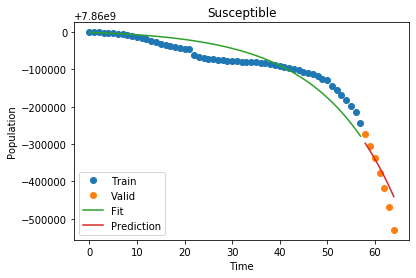

Susceptible MSLE: 3.0272e-11



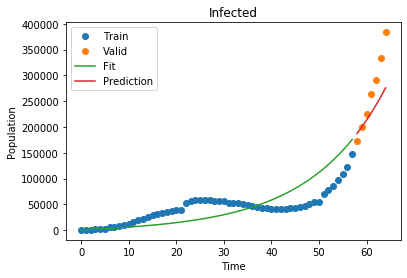

Infected MSLE: 3.3894e-02



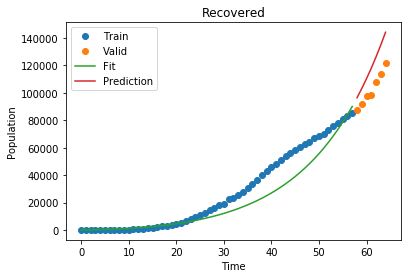

Recovered MSLE: 2.1760e-02



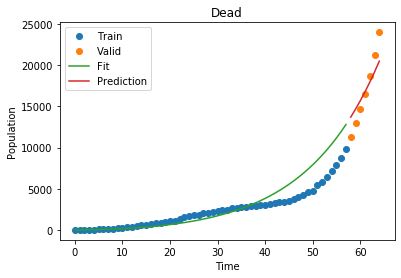

Dead MSLE: 1.3264e-02



In [62]:
ret = odeint(SDiIQRDe_ode, SIR0, np.concatenate([x_train, x_valid]),
             args=(N, alpha, beta, gamma, delta, epsilon, sigma))
S, Di, I, Q, R, De = ret.T
I = I + Q
S = S + Di

S_fit = S[:-valid_size]
S_pred = S[-valid_size:]
I_fit = I[:-valid_size]
I_pred = I[-valid_size:]
R_fit = R[:-valid_size]
R_pred = R[-valid_size:]
De_fit = De[:-valid_size]
De_pred = De[-valid_size:]

plot_data("Susceptible", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
plot_data("Infected", x_train, I_train, x_valid, I_valid, I_fit, I_pred)
plot_data("Recovered", x_train, R_train, x_valid, R_valid, R_fit, R_pred)
plot_data("Dead", x_train, De_train, x_valid, De_valid, De_fit, De_pred)

I = I - Q
S = S - E - Di

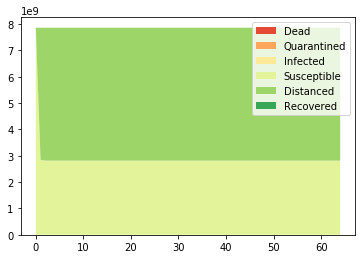

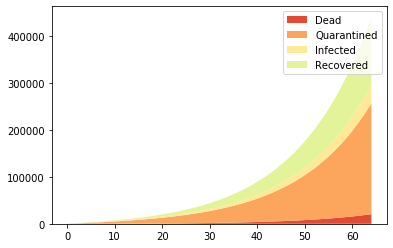

In [64]:
plt.stackplot(np.concatenate([x_train, x_valid]), [De, Q, I, S, Di, R],
        labels=["Dead", "Quarantined", "Infected", "Susceptible", "Distanced", "Recovered"],
        colors=pal)
plt.legend()
plt.show()

plt.stackplot(np.concatenate([x_train, x_valid]), [De, Q, I, R],
        labels=["Dead", "Quarantined", "Infected", "Recovered"],
        colors=pal)
plt.legend()
plt.show()

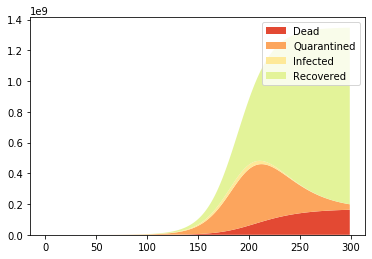

In [68]:
t = np.arange(300)
ret = odeint(SDiIQRDe_ode, SIR0, t,
             args=(N, alpha, beta, gamma, delta, epsilon, sigma))
S, Di, I, Q, R, De = ret.T

plt.stackplot(t, [De, Q, I, R],
        labels=["Dead", "Quarantined", "Infected", "Recovered"],
        colors=pal)
plt.legend()
plt.show()

In [69]:
inflection = datetime.strptime(world_df.iloc[0].name, "%m/%d/%y") + timedelta(days=int(np.argmax(I)))
death_toll = max(De)
confirmed = max(I + R)
simul_infected = max(I)
death_rate = death_toll / (confirmed + death_toll)
print("Predicted Total Confirmed Cases: {:.2e}".format(confirmed))
print("Predicted Death Rate: {:.2f}%".format(death_rate * 100))
print("Predicted Total Deaths: {:.2e}".format(death_toll))
print("Predicted Most Simultaneously Infected: {:.2e}".format(simul_infected))
print("Predicted Inflection Point:", inflection)

Predicted Total Confirmed Cases: 1.15e+09
Predicted Death Rate: 12.42%
Predicted Total Deaths: 1.63e+08
Predicted Most Simultaneously Infected: 3.17e+07
Predicted Inflection Point: 2020-07-31 00:00:00
